# Lab 1: Markov Decision Processes - Problem 2


## Lab Instructions
All your answers should be written in this notebook.  You shouldn't need to write or modify any other files.

**You should execute every block of code to not miss any dependency.**


*This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017. Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/. It is adapted from Berkeley Deep RL Class [HW2](https://github.com/berkeleydeeprlcourse/homework/blob/c1027d83cd542e67ebed982d44666e0d22a00141/hw2/HW2.ipynb) [(license)](https://github.com/berkeleydeeprlcourse/homework/blob/master/LICENSE)*

--------------------------

In [3]:
# basic setup
from misc import FrozenLakeEnv, make_grader
env = FrozenLakeEnv()
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
class MDP(object):
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)
GAMMA = 0.95

## Problem 2: Policy Iteration

The next task is to implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Below, you'll implement the first and second steps of the loop.

### Problem 2a: state value function

You'll write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.
Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You can solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [18]:
def compute_vpi(pi, mdp, gamma):
    # use pi[state] to access the action that's prescribed by this policy
    a = np.identity(mdp.nS)
    b = np.zeros(mdp.nS)
    
    for state in range(mdp.nS):
        for probability, nextstate, reward in mdp.P[state][pi[state]]:
            a[state][nextstate] -= gamma * probability
            b[state] += probability * reward
    V = np.linalg.solve(a,b)
    return V


Now let's compute the value of an arbitrarily-chosen policy. 


In [19]:
expected_val = np.array([  1.381e-18,   1.844e-04,   1.941e-03,   1.272e-03,   2.108e-18,
         0.000e+00,   8.319e-03,   1.727e-16,   3.944e-18,   2.768e-01,
         8.562e-02,  -7.242e-16,   7.857e-18,   3.535e-01,   8.930e-01,
         0.000e+00])

actual_val = compute_vpi(np.arange(16) % mdp.nA, mdp, gamma=GAMMA)
if np.all(np.isclose(actual_val, expected_val, atol=1e-4)):
    print("Test passed")
else:
    print("Expected: ", expected_val)
    print("Actual: ", actual_val)

Test passed


### Problem 2b: state-action value function

Next, you'll write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q^{\pi}(s, a) = \sum_{s'} P(s,a,s')[ R(s,a,s') + \gamma V^{\pi}(s')]$$


In [20]:
def compute_qpi(vpi, mdp, gamma):
    Qpi = np.zeros([mdp.nS, mdp.nA])
    for state in range(mdp.nS):
        for action in range(mdp.nA):
            for prob, nextstate, reward in mdp.P[state][action]:
                Qpi[state][action] += prob * (reward + gamma * vpi[nextstate])
    return Qpi

expected_Qpi = np.array([[  0.38 ,   3.135,   1.14 ,   0.095],
       [  0.57 ,   3.99 ,   2.09 ,   0.95 ],
       [  1.52 ,   4.94 ,   3.04 ,   1.9  ],
       [  2.47 ,   5.795,   3.23 ,   2.755],
       [  3.8  ,   6.935,   4.56 ,   0.855],
       [  4.75 ,   4.75 ,   4.75 ,   4.75 ],
       [  4.94 ,   8.74 ,   6.46 ,   2.66 ],
       [  6.65 ,   6.65 ,   6.65 ,   6.65 ],
       [  7.6  ,  10.735,   8.36 ,   4.655],
       [  7.79 ,  11.59 ,   9.31 ,   5.51 ],
       [  8.74 ,  12.54 ,  10.26 ,   6.46 ],
       [ 10.45 ,  10.45 ,  10.45 ,  10.45 ],
       [ 11.4  ,  11.4  ,  11.4  ,  11.4  ],
       [ 11.21 ,  12.35 ,  12.73 ,   9.31 ],
       [ 12.16 ,  13.4  ,  14.48 ,  10.36 ],
       [ 14.25 ,  14.25 ,  14.25 ,  14.25 ]])

Qpi = compute_qpi(np.arange(mdp.nS), mdp, gamma=0.95)
if np.all(np.isclose(expected_Qpi, Qpi, atol=1e-4)):
    print("Test passed")
else:
    print("Expected: ", expected_Qpi)
    print("Actual: ", Qpi)

Test passed


Now we're ready to run policy iteration!

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | -0.00000
   1      |      9        | 0.00000
   2      |      2        | 0.39785
   3      |      1        | 0.45546
   4      |      0        | 0.53118
   5      |      0        | 0.53118
   6      |      0        | 0.53118
   7      |      0        | 0.53118
   8      |      0        | 0.53118
   9      |      0        | 0.53118
  10      |      0        | 0.53118
  11      |      0        | 0.53118
  12      |      0        | 0.53118
  13      |      0        | 0.53118
  14      |      0        | 0.53118
  15      |      0        | 0.53118
  16      |      0        | 0.53118
  17      |      0        | 0.53118
  18      |      0        | 0.53118
  19      |      0        | 0.53118
Test succeeded


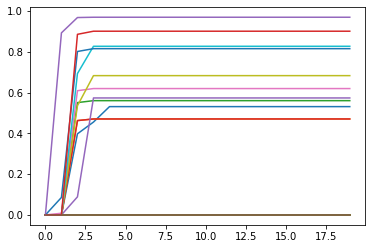

In [21]:
def policy_iteration(mdp, gamma, nIt, grade_print=print):
    Vs = []
    pis = []
    pi_prev = np.zeros(mdp.nS,dtype='int')
    pis.append(pi_prev)
    grade_print("Iteration | # chg actions | V[0]")
    grade_print("----------+---------------+---------")
    for it in range(nIt):        
        # YOUR CODE HERE
        # you need to compute qpi which is the state-action values for current pi
        vpi = compute_vpi(pis[-1], mdp, gamma)
        qpi = compute_qpi(vpi, mdp, gamma)
        
        pi = qpi.argmax(axis=1)
        grade_print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi
    return Vs, pis

expected_output = """Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | -0.00000
   1      |      9        | 0.00000
   2      |      2        | 0.39785
   3      |      1        | 0.45546
   4      |      0        | 0.53118
   5      |      0        | 0.53118
   6      |      0        | 0.53118
   7      |      0        | 0.53118
   8      |      0        | 0.53118
   9      |      0        | 0.53118
  10      |      0        | 0.53118
  11      |      0        | 0.53118
  12      |      0        | 0.53118
  13      |      0        | 0.53118
  14      |      0        | 0.53118
  15      |      0        | 0.53118
  16      |      0        | 0.53118
  17      |      0        | 0.53118
  18      |      0        | 0.53118
  19      |      0        | 0.53118"""

Vs_PI, pis_PI = policy_iteration(mdp, gamma=0.95, nIt=20, grade_print=make_grader(expected_output))
plt.plot(Vs_PI);